# A2C_20 time window_MlpLstmPolicy

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
mydrive_path = '/content/gdrive/MyDrive/STUDY/StartUP-Khv/07_A2C/BTC_RL_Trading_Bot'

Mounted at /content/gdrive


In [2]:
%pip install gym gym-anytrading stable-baselines3 # stable-baselines

     |████████████████████████████████| 171 kB 29.3 MB/s 
     |████████████████████████████████| 174 kB 53.6 MB/s 


In [3]:
import glob
import os
import json
import pandas as pd

COLUMNS = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closing_time', 'Volume_of_quoted_assets',
           'Number_of_transactions', 'Volume_purchased_by_buyer',
           'Volume_purchase_quote_for_buyer', 'Ignore']

data_fn_list = sorted(glob.glob(f'{mydrive_path}/BTCUSDT-1d/*.json'))

df = pd.DataFrame(columns=COLUMNS)
for fn in data_fn_list: # TODO for develop [:1]
    df_json = pd.read_json(fn)
    df_json.columns = COLUMNS
    df_json['Date'] = pd.to_datetime(df_json['Date'], unit='ms', origin='unix')
    df = df.append(df_json)
df.set_index('Date', inplace=True)
df.drop(columns=['Closing_time', 'Ignore', 'Volume_of_quoted_assets', 'Number_of_transactions', 'Volume_purchased_by_buyer',
           'Volume_purchase_quote_for_buyer'], inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2021-08-28,49069.90,49299.00,48346.88,48895.35,26681.063786
2021-08-29,48895.35,49632.27,47762.54,48767.83,32652.283473
2021-08-30,48767.84,48888.61,46853.00,46982.91,40288.350830


In [4]:
import plotly.graph_objs as go
fig = go.Figure()
#Add trace - OHLC need 4 arguments
fig.add_trace(go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']))
fig.show()

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Close'], line=dict(color='royalblue', width = 1.5, dash = 'dot')))
fig.show()

In [6]:
import gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import gym_anytrading


info: {'total_reward': 5846.999999999988, 'total_profit': 0.03963665249292214, 'position': 0}


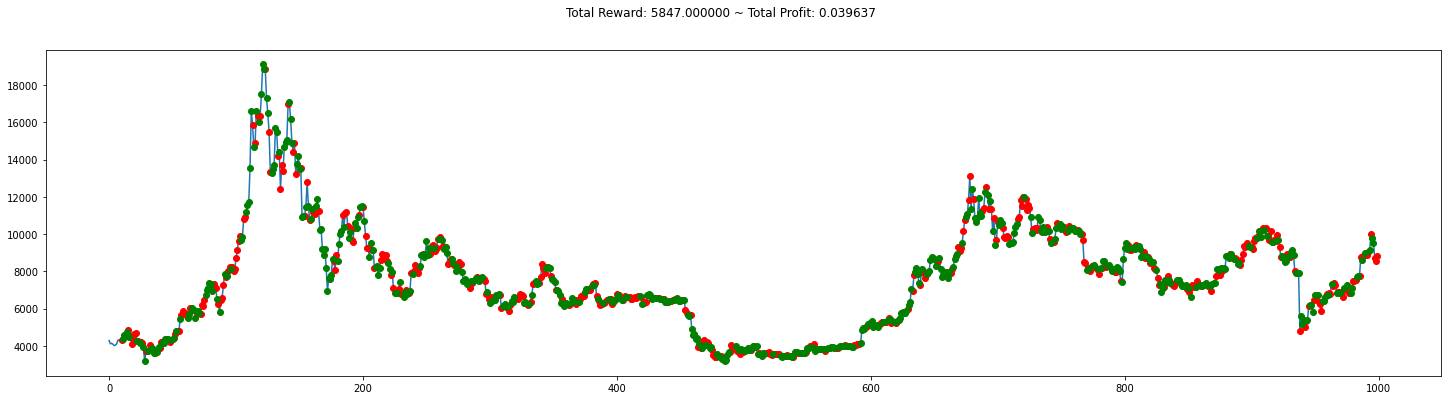

In [30]:
import matplotlib.pyplot as plt
env = gym.make('stocks-v0', df=df, frame_bound=(10,1000), window_size=10)
env.action_space
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break
plt.figure(figsize=(25,6))
plt.cla()
env.render_all()
plt.show()

In [38]:

env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(50,(len(df)-150)), window_size=50)
# env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(20,(len(df)-100)), window_size=20)
env = DummyVecEnv([env_maker])

model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=f'tmp/A2C_20_MlpPolicy') 
# model = A2C('MlpLstmPolicy', env, verbose=1, tensorboard_log=f'{mydrive_path}/A2C_20_MlpLstm') 
history = model.learn(total_timesteps=100000)

Using cpu device
Logging to tmp/A2C_20_MlpPolicy/A2C_5
------------------------------------
| time/                 |          |
|    fps                | 727      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.664   |
|    explained_variance | 0.00903  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -27.6    |
|    value_loss         | 1.82e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 727      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0.0216   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss    

info {'total_reward': -8252.510000000002, 'total_profit': 0.48147593357206997, 'position': 0}


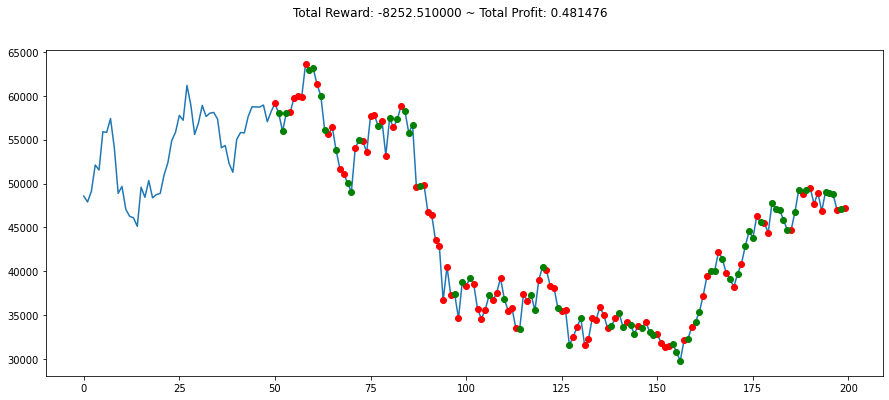

In [44]:
import numpy as np
#Setting up the Agent Environment
env = gym.make('stocks-v0', df=df, frame_bound=((len(df)-150),len(df)), window_size=50)
observation = env.reset()

while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

#Plotting our Model for Trained Trades
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [36]:
model.save(f'{mydrive_path}/A2C_20_time_window_MlpLstmPolicy_tradebot20')
# model = model.load(f'{mydrive_path}/A2C_20_time_window_MlpLstmPolicy_tradebot20')

plt.figure(figsize=(25,10))
plt.cla()
env.render_all()
plt.show()